# Idea

Set up the data in matrix form as day/store for each family. Then use SVD as a preprocessing step to pool data across stores. The idea here is to use a low-rank approximation of the original data, which is likely to reduce the noise due to the fact that the most important eigenvalues from the SVD should be related to the actual signal in the data, so it is used as a sort of denoising technique.

In [1]:
from storeSalesUtils.dataloading import load_stores, load_train, load_holidays, load_test, load_oil, DATA_FOLDER
from storeSalesUtils.plotting import plot_joint_plot, plot_autocorrelations
from storeSalesUtils.prophetPipeline import (prophetPipeline, parse_holidays, parse_oil_prophet, median_filter,
                                      visualize_forecasts, RMSLE, grangers_causation_matrix)

import pandas as pd
from pandas.errors import SettingWithCopyWarning
import numpy as np
from numpy.linalg import svd
import os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, grangercausalitytests

import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

from tqdm.auto import tqdm

import warnings
warnings.simplefilter("ignore", SettingWithCopyWarning)
warnings.simplefilter("ignore", FutureWarning)

plt.rcParams["figure.figsize"] = (16, 4)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
train = load_train()
stores = load_stores()
holidays = load_holidays()
oil = load_oil()
oil_prophet = parse_oil_prophet(oil)

test = load_test()

# only use two years of data available
maxDate = train.date.max()
minDate = maxDate - pd.DateOffset(years=2)
print('Using data within the dates: ', maxDate, minDate)
train = train[train.date.between(minDate, maxDate)]

# simulate test set scenario using the last 15 days of data for validation
val_dates = maxDate - pd.DateOffset(15)
train['split'] = np.where(train.date>=val_dates, 'validation', 'train')

train.head()

Using data within the dates:  2017-08-15 00:00:00 2015-08-15 00:00:00


,id,date,store_nbr,family,sales,onpromotion,split
1700028,1700028,2015-08-15,1,AUTOMOTIVE,3.0,0,train
1700029,1700029,2015-08-15,1,BABY CARE,0.0,0,train
1700030,1700030,2015-08-15,1,BEAUTY,0.0,0,train
1700031,1700031,2015-08-15,1,BEVERAGES,2845.0,5,train
1700032,1700032,2015-08-15,1,BOOKS,0.0,0,train


In [3]:
train.family.unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [5]:
family = 'AUTOMOTIVE'

train_dataMatrix = train[train.family==family]

train_dataMatrix = train_dataMatrix.pivot_table(values='sales', index='date', columns='store_nbr')
train_dataMatrix.columns = train_dataMatrix.columns.astype(str)

# if all entries are zero, drop those stores
all_zeros_condition = (train_dataMatrix==0).sum() >= 0.9*len(train_dataMatrix)
all_zero_stores = all_zeros_condition[all_zeros_condition].index.tolist()
train_dataMatrix = train_dataMatrix.drop(all_zero_stores, axis=1)

# use rolling mean as target. Drop first rows which are NaN
window = 14
train_dataMatrix_smoothed = train_dataMatrix.rolling(window).mean()[window-1::]

print(train_dataMatrix_smoothed.shape)
train_dataMatrix_smoothed.head()

(717, 54)


store_nbr,1,2,3,4,5,6,7,8,9,10,...,45,46,47,48,49,50,51,52,53,54
date,,,,,,,,,,,,,,,,,,,,,
2015-08-28,2.642857,6.214286,9.071429,3.714286,5.214286,4.000000,5.214286,6.357143,13.785714,2.928571,...,17.714286,14.785714,13.571429,15.285714,9.500000,9.357143,6.714286,0.0,3.285714,6.928571
2015-08-29,2.785714,6.857143,8.428571,3.500000,4.857143,4.285714,5.000000,6.857143,13.214286,2.857143,...,18.000000,14.428571,14.500000,14.357143,8.642857,9.928571,6.642857,0.0,3.642857,7.071429
2015-08-30,2.785714,6.500000,8.500000,3.428571,5.000000,4.500000,5.500000,6.571429,13.357143,2.857143,...,17.428571,14.785714,14.857143,14.000000,8.642857,9.928571,7.357143,0.0,4.000000,6.571429
2015-08-31,3.214286,6.500000,8.714286,3.428571,5.142857,4.642857,5.285714,6.785714,13.285714,2.857143,...,17.571429,14.785714,14.500000,14.357143,8.428571,9.785714,7.642857,0.0,4.285714,6.928571
2015-09-01,2.571429,6.642857,8.571429,3.785714,5.142857,4.857143,5.214286,6.500000,13.928571,2.857143,...,17.214286,14.214286,14.285714,14.571429,8.214286,9.571429,8.214286,0.0,4.571429,7.285714


In [6]:
u, s, vh = svd(train_dataMatrix_smoothed, full_matrices=True)
u.shape, s.shape, vh.shape

((717, 717), (54,), (54, 54))

In [7]:
u[:, :10].shape

(717, 10)

In [56]:
cumulative_comps = s.cumsum()/s.sum()

# select the number of components which account for some threshold of the cumulative singular values
thresh = 0.8
lowRank_components = np.where(cumulative_comps>thresh)[0][0]
train_lowRank = np.dot(u[:, :lowRank_components] * s[:lowRank_components], vh[:lowRank_components, :])

train_lowRank = pd.DataFrame(train_lowRank, index=train_dataMatrix_smoothed.index, columns=train_dataMatrix_smoothed.columns)

# standardize data
store_lowRank_means = train_lowRank.mean()
store_lowRank_stds = train_lowRank.std()
train_lowRank = (train_lowRank - store_lowRank_means)/store_lowRank_stds

# we want to ignore streaks of consecutive zeros, so we set this to NaN
aux = pd.DataFrame(np.where(train_dataMatrix_smoothed.rolling(7).mean() == 0, np.nan, 1),
                   index=train_lowRank.index, columns=train_lowRank.columns)
train_lowRank = train_lowRank * aux

# for holt_winters model
train_lowRank = train_lowRank.apply(lambda x: x.fillna(x.mean()), axis=0)

# # ignore extreme values:
# for col in train_lowRank.columns:
#     train_lowRank[col] = median_filter(train_lowRank, col, window=28, std=3)

train_lowRank['total'] = train_lowRank.sum(axis=1)
train_lowRank.head()

store_nbr,1,2,3,4,5,6,7,8,9,10,...,46,47,48,49,50,51,52,53,54,total
date,,,,,,,,,,,,,,,,,,,,,
2015-08-28,-0.959414,-1.898499,-1.625380,-0.732348,-1.438666,-0.427234,0.657380,1.033006,-0.017650,-0.046639,...,-0.211389,-0.940084,0.731396,-1.467406,-0.721343,-0.596639,-0.428989,-1.827965,-0.554307,-32.738577
2015-08-29,-1.319388,-1.833817,-1.870500,-0.417625,-1.637141,-0.365006,0.418077,0.779420,-0.247491,0.055021,...,-0.261814,-0.767513,0.576105,-1.579954,-0.658594,-0.640927,-0.477035,-1.712117,-0.758409,-32.854886
2015-08-30,-1.201628,-1.418198,-1.783945,-0.310021,-1.459711,-0.176691,0.398737,0.576618,-0.152779,0.109866,...,-0.217797,-0.694060,0.572080,-1.577246,-0.629725,-0.567738,-0.445842,-1.582018,-0.629987,-29.193783
2015-08-31,-1.030943,-1.072898,-1.644832,-0.306054,-1.303905,0.095221,0.518168,0.647770,-0.179937,0.190100,...,-0.258543,-0.760494,0.619368,-1.651132,-0.785583,-0.473625,-0.452693,-1.495399,-0.545515,-25.973165
2015-09-01,-1.354770,-1.030004,-1.853503,-0.128069,-1.202364,0.328685,0.436038,0.632213,-0.016867,0.168007,...,-0.365226,-0.740311,0.584075,-1.790163,-0.937514,-0.401270,-0.450701,-1.354061,-0.478922,-24.791174


In [57]:
from hts import HTSRegressor

In [58]:
stores = train_lowRank.drop('total', axis=1).columns.to_list()

hierarchy = {
    'total': stores,
}
stores_dict = dict(zip(stores, [[s] for s in stores]))

hierarchy = {**hierarchy}
# hierarchy

In [82]:
# reg = HTSRegressor(model='prophet', revision_method='OLS', **{'yearly_seasonality':False, 'weekly_seasonality':True})
# reg = reg.fit(df=train_lowRank, nodes=hierarchy, show_warnings=False)

In [77]:
# reg = HTSRegressor(model='holt_winters', revision_method='OLS', **{'seasonal_periods':7})
# reg = reg.fit(df=train_lowRank, nodes=hierarchy, show_warnings=False)

Fitting models: 100%|██████████████████████| 19/19 [00:00<00:00, 157.37it/s]


In [78]:
# reg = HTSRegressor(model='auto_arima', revision_method='OLS',
#                    **{
#                        'm':7, 'seasonal':True, 'start_p':0,
#                        'start_q':0, 'max_p':2, 'max_q':2
#                    })

# reg = reg.fit(df=train_lowRank, nodes=hierarchy, show_warnings=False)

In [79]:
preds = reg.predict(steps_ahead=16)

Fitting models: 100%|██████████████████████| 19/19 [00:00<00:00, 185.78it/s]


In [80]:
# maybe use last 15 days to compute the means
prev_15 = train_dataMatrix_smoothed[train_dataMatrix_smoothed.index >= pd.to_datetime('2017-07-14')]

# go back to actual scale of values
# adjusted_preds = (preds.drop('total', axis=1)*train_dataMatrix_smoothed.std())+train_dataMatrix_smoothed.mean()
adjusted_preds = (preds.drop('total', axis=1)*prev_15.std())+prev_15.mean()

for col in all_zero_stores:
    adjusted_preds[col] = 0

# we want only non-negative predictions
adjusted_preds = adjusted_preds.where(adjusted_preds>=0, 0)

adjusted_preds.describe()

,1,2,3,4,5,6,7,8,9,10,...,45,46,47,48,49,50,51,52,53,54
count,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,...,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000
mean,4.954539,6.685633,11.990922,3.497115,5.886973,6.392321,5.712772,5.650819,28.691326,1.217765,...,17.424160,12.858979,20.287975,13.612310,12.206883,10.567454,8.349658,12.417161,10.274881,6.647448
std,0.291077,1.077154,1.069115,0.786028,0.636336,1.663209,0.293777,0.971042,34.948204,0.325097,...,0.638374,0.771054,1.628055,1.494187,1.036388,0.887773,0.398304,0.685791,0.835777,0.282654
min,3.949238,4.112405,9.622730,1.361051,3.625504,1.588923,4.914270,1.942805,0.000000,0.413331,...,15.511077,10.621573,15.124913,10.629853,9.746910,8.453353,7.347907,10.143565,8.266439,5.873641
25%,4.775827,5.881803,11.245860,3.001518,5.390353,5.402335,5.502348,5.165654,0.000000,0.999193,...,16.977028,12.392315,19.297448,12.348559,11.527269,9.865971,8.063785,11.962213,9.657024,6.471084
50%,4.954653,6.624188,11.941179,3.436955,5.916987,6.698281,5.691281,5.661367,11.482907,1.233376,...,17.448361,12.961562,20.520926,13.892234,12.285436,10.527610,8.340444,12.410607,10.283057,6.646067
75%,5.168495,7.421332,12.766040,4.061666,6.397125,7.582150,5.951787,6.282023,49.105893,1.444043,...,17.869803,13.449886,21.249111,14.648720,12.853412,11.199286,8.599229,12.825622,10.855798,6.811908
max,5.594326,9.288512,14.513321,5.467013,7.525745,9.953965,6.289538,7.951174,133.652502,1.975418,...,19.186734,14.299975,24.589582,17.532356,15.449445,13.167380,9.590230,14.277011,12.352749,7.391947


<AxesSubplot: >

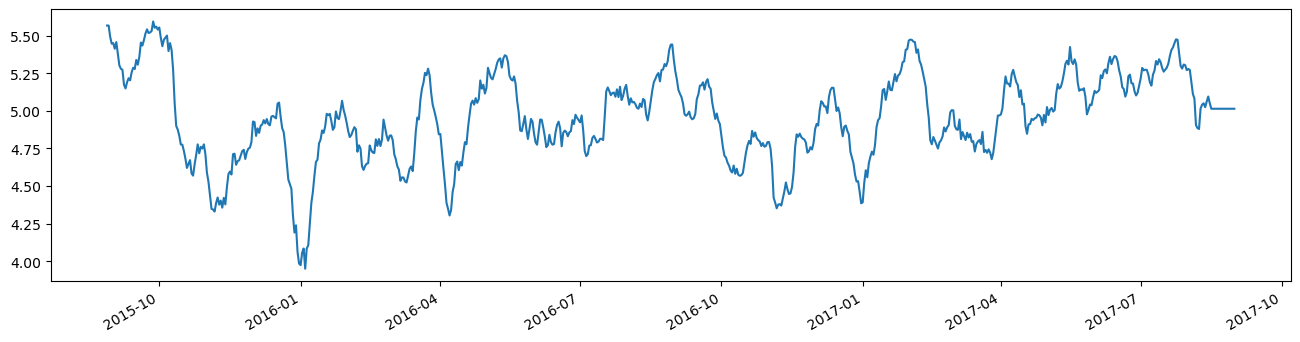

In [81]:
adjusted_preds['1'].plot()

<AxesSubplot: >

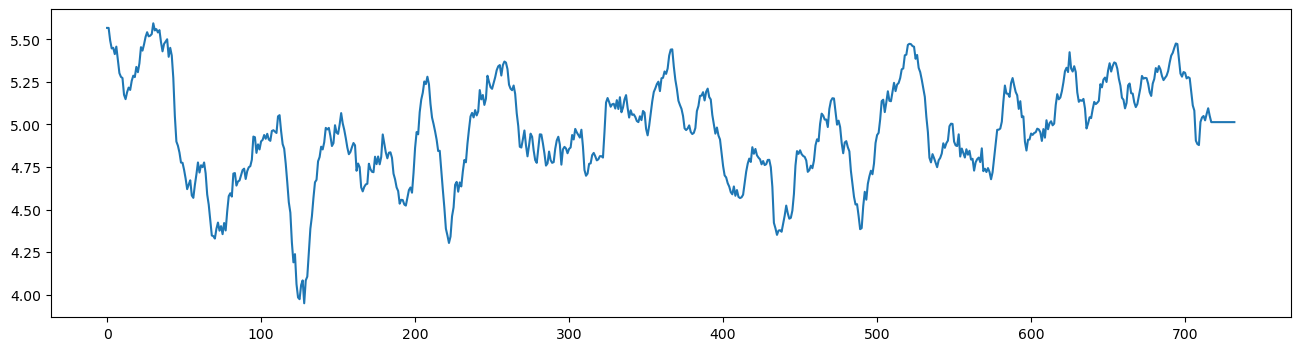

In [74]:
aux = adjusted_preds.melt(ignore_index=False).reset_index()
aux[aux.variable=='1'].value.plot()

In [75]:
test_prediction = adjusted_preds.melt(ignore_index=False).reset_index()
test_prediction.columns = ['date', 'store_nbr', 'sales']
test_prediction['family'] = family

test_prediction['store_nbr'] = test_prediction.store_nbr.astype(int)

test_prediction = test_prediction.merge(test, on=['date', 'store_nbr', 'family'])

test_prediction[['id', 'sales']]

,date,store_nbr,sales,family,id,onpromotion
0,2017-08-16,1,5.013552,AUTOMOTIVE,3000888,0
1,2017-08-17,1,5.013552,AUTOMOTIVE,3002670,0
2,2017-08-18,1,5.013552,AUTOMOTIVE,3004452,0
3,2017-08-19,1,5.013552,AUTOMOTIVE,3006234,0
4,2017-08-20,1,5.013552,AUTOMOTIVE,3008016,0
...,...,...,...,...,...,...
859,2017-08-27,54,6.289291,AUTOMOTIVE,3022107,0
860,2017-08-28,54,6.289291,AUTOMOTIVE,3023889,0
861,2017-08-29,54,6.289291,AUTOMOTIVE,3025671,0
862,2017-08-30,54,6.289291,AUTOMOTIVE,3027453,0


<AxesSubplot: >

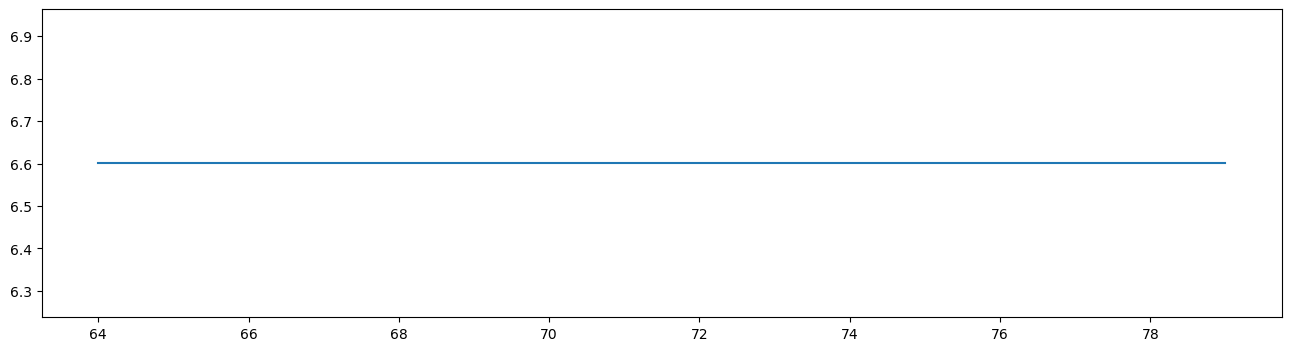

In [76]:
test_prediction[test_prediction.store_nbr==5].sales.plot()